<a href="https://colab.research.google.com/github/beta996/Twitter-Sentiment-Analysis/blob/main/MLproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [147]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import defaultdict
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
%load_ext google.colab.data_table

# **Preparing main dataset**

In [ ]:
df1 = pd.read_csv('gdrive/MyDrive/ML_project/Twitter_Data.csv')

In [ ]:
df1.shape

(162980, 2)

In [ ]:
df1.isnull().sum()

text        4
category    7
dtype: int64

In [ ]:
df1.dropna(axis=0, inplace=True)

In [ ]:
df1 = df1.rename(columns={'clean_text':'text'})
df1['category'] = df1['category'].astype(int)

In [ ]:
df1.head()

,text,category
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [ ]:
df2 = pd.read_csv('gdrive/MyDrive/ML_project/apple-twitter-sentiment-texts.csv')

In [ ]:
df2 = df2.rename(columns={'sentiment':'category'})

In [ ]:
df2.isnull().sum()

text        0
category    0
dtype: int64

In [ ]:
df2.head()

,text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [ ]:
df3 = pd.read_csv('gdrive/MyDrive/ML_project/Tweets.csv')

In [ ]:
df3.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df3 = df3[['text', 'airline_sentiment']]

In [ ]:
df3 = df3.rename(columns={'airline_sentiment':'category'})
df3['category'] = df3['category'].map({'negative': -1, 'neutral': 0, 'positive':1})

In [ ]:
df3.isnull().sum()

text        0
category    0
dtype: int64

In [ ]:
df3.head()

,text,category
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,-1
4,@VirginAmerica and it's a really big bad thing...,-1


In [ ]:
df = pd.concat([df1, df2, df3], ignore_index=True)
df_oryginal = df.copy()

# **Preprocessing of main dataset**

In [ ]:
df.shape

(179239, 2)

In [ ]:
df['category'].value_counts()

 1    74755
 0    59111
-1    45373
Name: category, dtype: int64

In [ ]:
# there are hyperlinks
[itm[0] for itm in df['text'].str.findall('http?:\/\/[^\s]+|www\.[^\s]') if len(itm)>0]

In [ ]:
# there are hashtags
[itm[0] for itm in df['text'].str.findall('#\w+') if len(itm)>0]

In [ ]:
# there are users
[itm[0] for itm in df['text'].str.findall('@[\w]+') if len(itm)>0]

In [ ]:
# there are numbers
[itm[0] for itm in df['text'].str.findall('.*\d+.*') if len(itm)>0]

In [ ]:
def preprocess(df):
  special_chars = ['~', ':', "'", '+', '[', '\\', '@', '^', '{', '%', '(', '-', '"', '*', '|', ',', '&', '<', '`', '}', '.', '_', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/']

  df['text'] = df['text'].str.lower() # convert to lowercase
  df['text'] = df['text'].str.replace('http?:\/\/[^\s]+|www\.[^\s]', '', regex=True) # remove hyperlinks
  df['text'] = df['text'].str.replace('@[\w]+', '', regex=True) # remove users
  df['text'] = df['text'].str.replace('#\w+', '', regex=True) # remove hashtags
  df['text'] = df['text'].str.replace('\d+', '', regex=True) # remove numbers

  for char in special_chars:
    df['text'] = df['text'].str.replace(char, '') # special characters

  # remove stopwords
  nltk.download('stopwords')
  stop_words = []
  with open('/root/nltk_data/corpora/stopwords/english','r') as file:
    stop_words = [word for word in file.read().splitlines()]
  df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
  df = stemming(df)
  return df

In [ ]:
def stemming(df:pd.DataFrame):
  stemmer = SnowballStemmer("english")
  unstemmed = df['text'].str.split() # word tokenizing
  stemmed = unstemmed.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
  for i in range(len(stemmed)):
    stemmed[i] = ' '.join(stemmed[i])
  df['text'] = stemmed
  return df

In [ ]:
preprocessed = preprocess(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
compare = pd.DataFrame
compare = preprocessed.tail()
compare['before'] = df_oryginal['text']
compare

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,category,before
179234,thank got differ flight chicago,1,@AmericanAir thank you we got on a different f...
179235,leav minut late flight warn communic minut lat...,-1,@AmericanAir leaving over 20 minutes Late Flig...
179236,pleas bring american airlin,0,@AmericanAir Please bring American Airlines to...
179237,money chang flight dont answer phone suggest m...,-1,"@AmericanAir you have my money, you change my ..."
179238,ppl need know mani seat next flight plz put us...,0,@AmericanAir we have 8 ppl so we need 2 know h...


In [141]:
def remove_empty_cells(df):
  df['text'].replace('', np.nan, inplace=True)
  df.dropna(subset=['text'], inplace=True)

In [145]:
print(f"Shape before empty rows deletion: {preprocessed.shape}")
remove_empty_cells(preprocessed)
print(f"Shape after empty rows deletion: {preprocessed.shape}")

Shape before empty rows deletion: (179239, 2)
Shape after empty rows deletion: (179142, 2)


# **Visualization**

In [ ]:
def draw_clouds(series):
  wordcloud = WordCloud(collocations=False).generate(' '.join(series))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

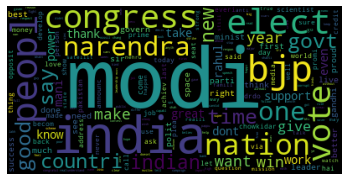

In [ ]:
# for positive
draw_clouds(preprocessed[preprocessed['category']==1]['text'])

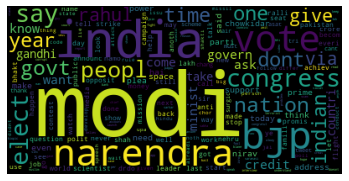

In [ ]:
# for neutral
draw_clouds(preprocessed[preprocessed['category']==0]['text'])

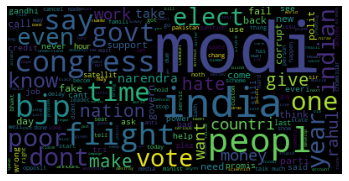

In [ ]:
# for negative
draw_clouds(preprocessed[preprocessed['category']==-1]['text'])

In [ ]:
def draw_frequebcy_bars(series):
  freq_dict = defaultdict(int)
  for sample in series:
    for word in word_tokenize(sample):
      freq_dict[word] += 1
  patrial = dict(sorted(freq_dict.items(), key=lambda pair: pair[1], reverse=True)[:20])
  keys = tuple(patrial.keys())
  values = patrial.values()
  plt.barh(keys, values)

Text(0.5, 0, 'Count')

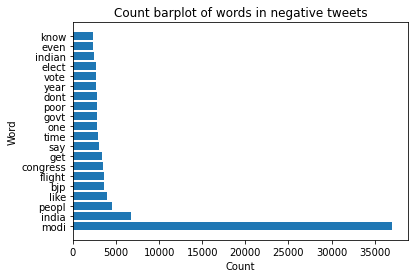

In [ ]:
# negative
draw_frequebcy_bars(preprocessed[preprocessed['category']==-1]['text'])
plt.title('Count barplot of words in negative tweets')
plt.ylabel('Word')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

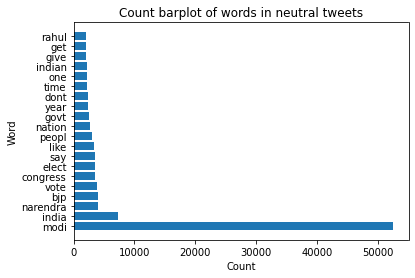

In [ ]:
# neutral
draw_frequebcy_bars(preprocessed[preprocessed['category']==0]['text'])
plt.title('Count barplot of words in neutral tweets')
plt.ylabel('Word')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

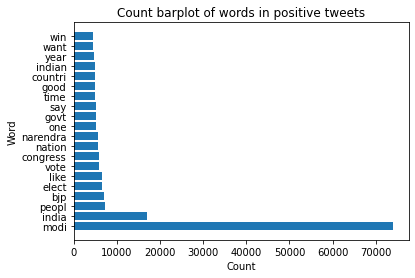

In [ ]:
# positive
draw_frequebcy_bars(preprocessed[preprocessed['category']==1]['text'])
plt.title('Count barplot of words in positive tweets')
plt.ylabel('Word')
plt.xlabel('Count')

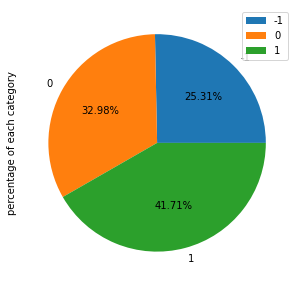

In [ ]:
categories = preprocessed.groupby('category').count()
categories["percentage of each category"] = categories["text"] * 100 / sum(categories["text"])  
categories.plot(kind = "pie",y="percentage of each category",legend=True,figsize=(12,5),autopct="%.2f%%")


In [148]:
tweets_stats = pd.DataFrame()
tweets_stats["text"] = preprocessed["text"].astype(str)
tweets_stats["category"] = preprocessed["category"]
tweets_stats['length'] = tweets_stats["text"].apply(len)
tweets_stats.groupby("category")["length"].describe()


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
-1,45367.0,92.215575,46.176202,3.0,56.0,83.0,130.0,243.0
0,59028.0,60.904622,40.505835,1.0,31.0,51.0,80.0,249.0
1,74747.0,95.854723,47.276879,3.0,57.0,92.0,135.0,244.0


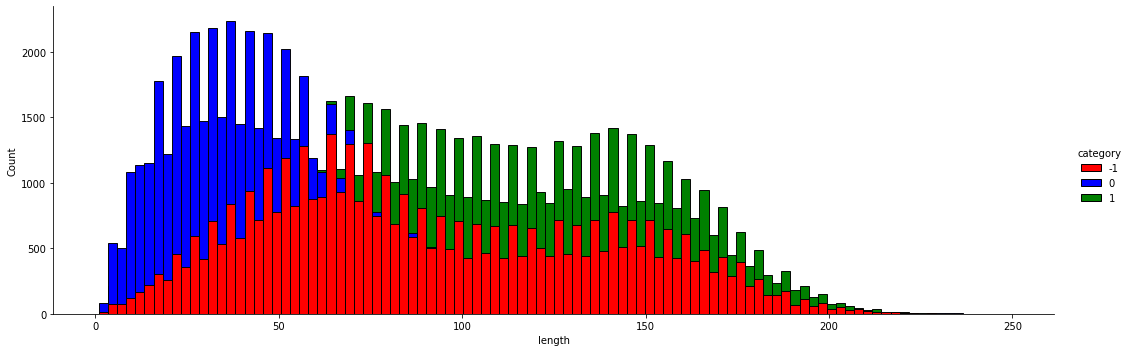

In [171]:
sns.displot(height = 5, data = tweets_stats, x= "length", hue= "category" ,palette={-1:"r",0:"b",1:"g"}, bins = 100,aspect= 3, alpha = 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179142 entries, 0 to 179238
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      179142 non-null  object
 1   category  179142 non-null  int64 
 2   length    179142 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 10.5+ MB
